In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

In [7]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

##### 2deg * 2deg

In [8]:
PREFIX = 'random_field1'
lsbg_cat = Table.read(f'./Catalog/{PREFIX}/{PREFIX}_cutout_cat_{PREFIX}.fits')
lsbg_cat.sort('viz-id')
len(lsbg_cat)

385

Run `deploy_random.py` to run scarlet (both vanilla and spergel) on this sample.

### Analysis: make cuts to rule out junks

In [10]:
import kuaizi
from kuaizi.display import plot_measurement
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='default', usetex=False)

In [11]:
method = 'vanilla'
meas_cat = Table.read(f'./Catalog/random_field1/{method}/_lsbg_meas_{method}_{method}_0_385_nosegmap.fits')
seg_meas_cat = Table.read(f'./Catalog/random_field1/{method}/_lsbg_meas_{method}_{method}_0_385_segmap.fits')

In [12]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

# of Candy: 73
# of Gal: 219
# of Junk: 93


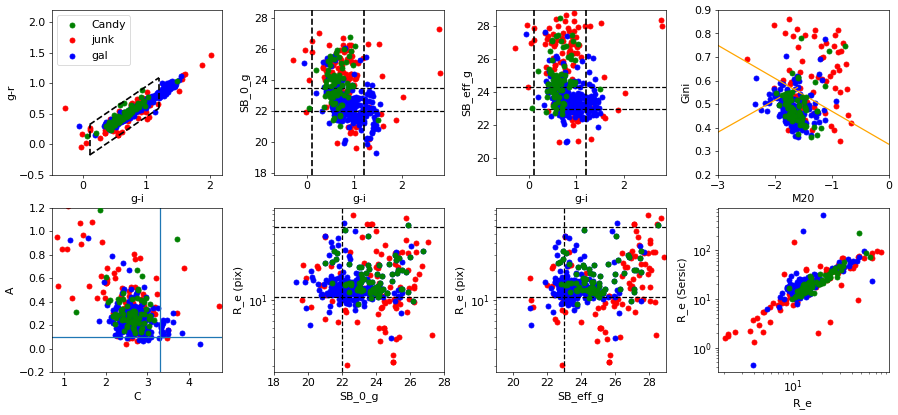

In [13]:
plot_measurement(lsbg_cat, meas_cat)

In [14]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [15]:
color_bound = [0.1, 1.2]
half_width = 0.25

# Color cuts
mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

# Size cuts
min_size = 1.8
max_size = 12
mask &= (seg_meas_cat['rhalf_circularized'] >= min_size /
         0.168) & (seg_meas_cat['rhalf_circularized'] <= max_size / 0.168)

# SB cuts
min_cen_SB = 22.5
min_eff_SB = 23.0
mask &= (meas_cat['SB_0'][:, 0] > min_cen_SB)
mask &= (meas_cat['SB_eff_avg'][:, 0] > min_eff_SB)  # Cuts based on JG votes

# Shape cuts
mask &= (meas_cat['ell_sym'] < 0.65)

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
mask &= ~((meas_cat['M20'] < -1.6) & (
    meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))
mask &= (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.37)

mask &= (meas_cat['C'] < 3.5) & (meas_cat['C'] > 1.8)
#mask &= (meas_cat['A_outer'] <= 0.13)
mask &= (meas_cat['A'] < 0.7)

# mask &= (seg_meas_cat['rhalf_circularized'] > 1.8 / 0.168) & (seg_meas_cat['rhalf_circularized'] < 12 / 0.168)

print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 45
Gal: 63
Junk: 9


# of Candy: 45
# of Gal: 63
# of Junk: 9


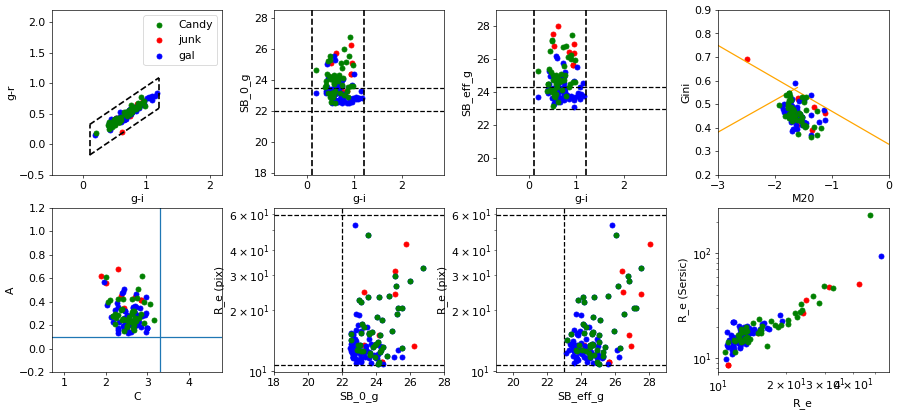

In [16]:
plot_measurement(lsbg_cat[mask], meas_cat[mask])

In [17]:
# Save this mask
method = 'vanilla'
np.save(f'./Catalog/{PREFIX}/{method}/lsbg_cuts_mask_{method}.npy', mask)

### Load Spergel catalog, apply mask, associate them with UDG hosts, apply UDG criteria

In [18]:
method = 'spergel'
meas_cat = Table.read(f'./Catalog/{PREFIX}/{method}/_lsbg_meas_{method}_{method}_0_385_nosegmap.fits')
cuts_cat = hstack([lsbg_cat[mask], meas_cat[mask]])

In [19]:
### Load UDG catalog at z=0.02-0.04
udg_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z002_004/udg_z002_004_spergel_after_viz.fits')

In [20]:
80 / len(cuts_cat)

0.6837606837606838

In [21]:
_udg_cat_ind = []
_udg_host_ang_dist = []

for k in range(20):
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    _cuts_cat = cuts_cat[inds]

    UDG_num = []
    for i in range(100):
        inds = np.random.randint(0, len(udg_cat), len(_cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion
        
        rhalf_phys = _cuts_cat['rhalf_spergel'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        _cuts_cat['rhalf_circularized_phys'] = rhalf_phys
        ### UDGs
        flag = (_cuts_cat['rhalf_circularized_phys'] > 1.5) & (_cuts_cat['SB_eff_avg'][:, 0] >= 24.6)
        if i == 0 and k == 0:
            fake_udg_cat = _cuts_cat[flag]
        else:
            fake_udg_cat = vstack([fake_udg_cat, _cuts_cat[flag]])
        _udg_cat_ind.append(_cuts_cat[flag]['viz-id'].data)
        _udg_host_ang_dist.append(ang_diam_dist[flag])
        UDG_num.append(np.sum(flag))
#     print(np.mean(UDG_num) / len(cuts_cat) * 100)

fake_udg_cat['host_ang_diam_dist'] = np.hstack(_udg_host_ang_dist)

In [22]:
# Correct for the measurement error 
SB_g_meas = fake_udg_cat['SB_eff_avg'][:, 0].data
R_e = fake_udg_cat['rhalf_spergel'].data * 0.168


with open('./Catalog/completeness/Re_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
R_e += f_med(SB_g_meas)
R_e_std = f_std(SB_g_meas)

ang_diam_dist = fake_udg_cat['host_ang_diam_dist'].data # not consider peculiar motion
R_e_phys = R_e / 206265 * ang_diam_dist * 1000 # in kpc
R_e_phys_std = R_e_std / 206265 * ang_diam_dist * 1000 # in kpc

In [24]:
with open('./Catalog/completeness/deblend_detection_comp.pkl', 'rb') as f:
    f_comp = pickle.load(f)
    
comp = np.array([f_comp(*p)[0] for p in zip(R_e, SB_g_meas)])

In [30]:
n_bins = 10
range_0 = np.array([np.log10(1.5), np.log10(12)])
edges_0 = np.histogram_bin_edges(np.log10(R_e_phys), bins=n_bins,
                                 range=range_0)

_ns = []
for i in range(100):
    _R_e_phys = R_e_phys + np.random.normal(loc=0, scale=R_e_phys_std)
    # account for measurement error, we re-generate new R_e w.r.t R_e_std
    _ns.append(np.histogram(
        np.log10(_R_e_phys), 
        bins=n_bins,
        range=range_0, 
        weights=None)[0])
_ns = np.array(_ns) / (0.68 * 4 * 20 * 100) # per deg2

Text(0, 0.5, '$n\\ [\\rm dex^{-1}]$')

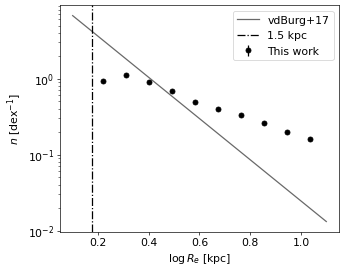

In [31]:
n_cen = np.nanmean(_ns, axis=0)
n_std = np.nanstd(_ns, axis=0)

bin_cen = (edges_0[:-1] + edges_0[1:]) / 2
plt.errorbar(bin_cen, n_cen, yerr=n_std, fmt='ok', 
             markersize=6, label='This work')

    
x = np.linspace(0.1, 1.1)
plt.plot(x, 10**(-2.71 * x + 1.1), color='dimgray', label='vdBurg+17')

plt.axvline(np.log10(1.5), ls='-.', color='k', label='1.5 kpc')
# plt.text(np.log10(1.6), 0.1, '1.5 kpc', color='gray')
plt.legend()

plt.yscale('log')
plt.xlabel(r'$\log\,R_e\ [\rm kpc]$')
plt.ylabel(r'$n\ [\rm dex^{-1}]$')

In [32]:
np.save('./Catalog/completeness/bkg_size.npy', np.vstack([n_cen, n_std]))

In [25]:
inds = np.random.randint(0, len(cuts_cat), 80)
cuts_cat = cuts_cat[inds]

In [26]:
percentages = []
errors = []

In [27]:
_udg_cat_ind = []
for k in range(20):
    cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_wavelet.fits')
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    cuts_cat= cuts_cat[inds]
    UDG_num = []
    for i in range(100):
        inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

        rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_circularized_phys'] = rhalf_phys

        rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_ellip_phys'] = rhalf_phys
        cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
        BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
        V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
        V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
        log_ML_V = 1.493 * BV - 0.681
        M = (4.83 - V_abs) / (2.5) + log_ML_V
        cuts_cat['log_m_star'] = M
        ### UDGs
        flag = (cuts_cat['rhalf_circularized_phys'] > 1.5) & (cuts_cat['SB_0'][:, 0] >= 24.)
        # & (cuts_cat['sersic_ell'] < 0.7)
        _udg_cat_ind.append(cuts_cat[flag]['viz-id'].data)
        UDG_num.append(np.sum(flag))
    percentages.append(np.mean(UDG_num) / len(cuts_cat) * 100)
    errors.append(np.std(UDG_num) / len(cuts_cat) * 100)

In [29]:
print('Background percentage (%):', 
      round(np.mean(percentages), 2), 
      '+-', round(np.std(percentages), 2), 
      '+-', round(np.mean(errors), 2))

Background percentage (%): 21.64 +- 2.46 +- 1.59


In [31]:
len(udg_cat) * 0.8

337.6

Text(0, 0.5, '$\\log\\ r_{e}^{\\rm circ}\\ [\\rm pc]$')

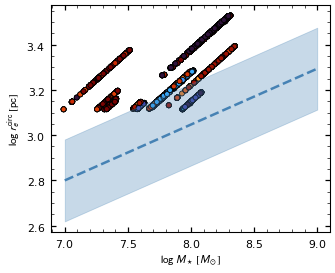

In [194]:
_udg_cat_ind = []
fig, ax = plt.subplots()

for k in range(20):
    cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    cuts_cat= cuts_cat[inds]
    UDG_num = []
    for i in range(50):
        inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

        rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_circularized_phys'] = rhalf_phys

        rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_ellip_phys'] = rhalf_phys
        cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
        BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
        V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
        V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
        log_ML_V = 1.493 * BV - 0.681
        M = (4.83 - V_abs) / (2.5) + log_ML_V
        cuts_cat['log_m_star'] = M
        cuts_cat['V_abs'] = V_abs
        ### UDGs
        flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
        _udg_cat_ind.append(cuts_cat[flag]['viz-id'].data)
        UDG_num.append(np.sum(flag))
        
        _udg_cat = cuts_cat[flag]
        sct = plt.scatter(_udg_cat['log_m_star'], 
                    np.log10(_udg_cat['rhalf_circularized_phys']) + 3, 
                    c=_udg_cat['viz-id'],#_udg_cat['mag'][:, 0] - _udg_cat['mag'][:, 2],
                    label='UDGs')
        
    percentages.append(np.mean(UDG_num) / len(cuts_cat) * 100)
    errors.append(np.std(UDG_num) / len(cuts_cat) * 100)
    
x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
#plt.legend(loc='lower right')

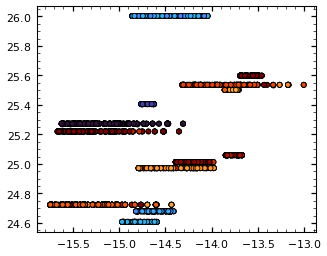

In [204]:
_udg_cat_ind = []
fig, ax = plt.subplots()

for k in range(20):
    cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')
    inds = np.random.choice(np.arange(len(cuts_cat)), size=80, replace=False)
    cuts_cat= cuts_cat[inds]
    UDG_num = []
    for i in range(50):
        inds = np.random.randint(0, len(udg_cat), len(cuts_cat))
        ang_diam_dist = udg_cat['host_ang_diam_dist'][inds] # not consider peculiar motion

        rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_circularized_phys'] = rhalf_phys

        rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
        cuts_cat['rhalf_ellip_phys'] = rhalf_phys
        cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
        BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
        V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
        V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
        log_ML_V = 1.493 * BV - 0.681
        M = (4.83 - V_abs) / (2.5) + log_ML_V
        cuts_cat['log_m_star'] = M
        cuts_cat['V_abs'] = V_abs
        ### UDGs
        flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
        _udg_cat_ind.append(cuts_cat[flag]['viz-id'].data)
        #print(np.sum(flag))
        UDG_num.append(np.sum(flag))
        
        _udg_cat = cuts_cat[flag]
        sct = plt.scatter(_udg_cat['V_abs'], 
                  _udg_cat['SB_0'][:, 0], 
            c=_udg_cat['viz-id'])
        
    percentages.append(np.mean(UDG_num) / len(cuts_cat) * 100)
    errors.append(np.std(UDG_num) / len(cuts_cat) * 100)


In [197]:
cuts_cat = Table.read(f'./Catalog/{PREFIX}/lsbg_{PREFIX}_after_cuts_JG.fits')

In [202]:
(cuts_cat['SB_eff_avg'][:, 0] >= 25.2) == (cuts_cat['SB_0'][:, 0] >= 24.5)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

(-12.0, -16.0)

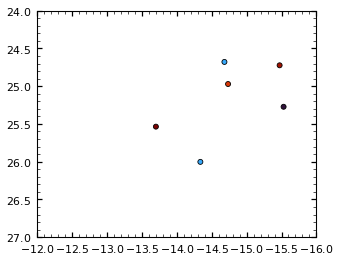

In [195]:
sct = plt.scatter(_udg_cat['V_abs'], 
                  _udg_cat['SB_0'][:, 0], 
            c=_udg_cat['viz-id'])
aa
plt.ylim(27, 24)
plt.xlim(-12, -16)

In [193]:
print('Background percentage (%):', 
      round(np.mean(percentages), 2), 
      '+-', round(np.std(percentages), 2), 
      '+-', round(np.mean(errors), 2))

Background percentage (%): 5.73 +- 1.62 +- 1.06


In [176]:
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

In [7]:
from PIL import Image

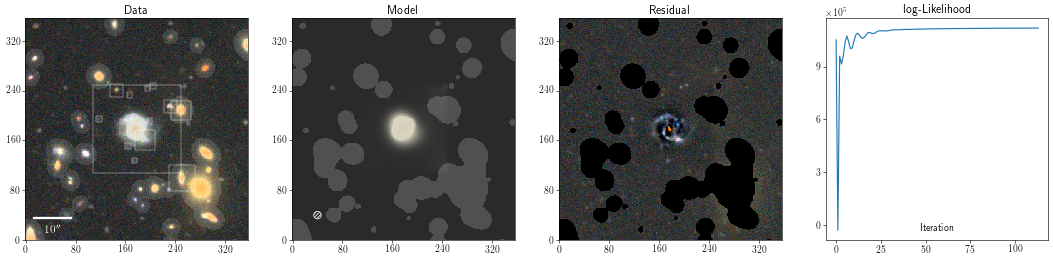

In [8]:
Image.open('./Figure/random_field/random_field-11-zoomin-wavelet.png')

In [14]:
# Table.read('/tigress/jiaxuanl/Data/HSC/LSBG/Catalog/random_field/random_field_cutout_cat_random_field.fits')['viz-id']

In [10]:
Table.read('./Catalog/random_field1/vanilla/_lsbg_meas_vanilla_vanilla_0_1_nosegmap.fits')a

ID,flux [4],mag [4],flux_circ [4],flux_ellip [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],SB_eff_avg [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,rhalf_circularized,rhalf_spergel,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,A_outer,A_shape,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11,1351.8564453125 .. 3487.21484375,19.172672271728516 .. 18.143802642822266,1308.3974609375 .. 3375.109130859375,1308.7745361328125 .. 3376.081787109375,22.057159423828125 .. 21.028289794921875,23.75481414794922 .. 22.72594451904297,23.795576095581055 .. 22.766706466674805,23.157758712768555 .. 22.128889083862305,250.9280764390494,250.31200835161735,247.84458343528684,249.35892740296617,0.2627317415374718,0.2681625988348981,0.7042938575883512,0.6845855749870591,14.969643253206927,17.363268958571386,14.853841756690928,nan,7.123019004405474,14.445893005841318,23.525865570971977,0.477429047836379,-1.7585686830411758,-0.3780381158623891,-0.09878628958470825,2.594407540178203,0.23165650963765888,0.4406529161418085,0.6764057754508804,0.025912737094352562,1.249105131358901,16.270650856760298,0.1099793835258732,0.513833908985502,247.41737314226205,249.23824072880618,0.4640229047230237,0.0,0.0
